## LSE for IEEE 118 bus system

To run this for a different system, you need:\
bdata.csv: The branch data of the system with each row being the individual branches, and:
        Column 1: From bus \
        Column 2: To bus\
        Column 3: Resistance (R)\
        Column 4: Reactance (X)\
        Column 5: Susceptance (B)\
        Column 6: Transformer tap ratio ($\tau$), set to 1 if NA

* 32 is the number of PMUs
* 162 is the total number of measurements (32 voltage, m=130 currents)
* z = Hx +v , H = B  x_hat = [(B^T.B)^-1 . B^T].z

In [1]:
# import the required packages
from ctypes import c_double
import numpy as np
import scipy.stats as stats
np.random.seed(123)

import pandas as pd
import matplotlib.pyplot as plt
import math
import cmath
# from linear_state_estimation import *
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
# from noise_models import *

In [2]:
# Define the LSE function

class linear_state_estimator():
    """docstring for ClassName"""
    def __init__(self, num_bus, bus_system , add_bus, branch_data):

        self.num_bus = num_bus
        self.add_bus = add_bus
        self.pmu_loc = {
            11: [8, 9, 10, 26, 30, 38, 63, 64, 65, 68, 81] ,
            13: [8, 9, 10, 26, 30, 38, 63, 64, 65, 68, 81, 87, 111] ,
            32: [1,5,10,12,13,17,21,25,28,34,37,41,45,49,53,56,62,64,72,73,75,77,80,85,87,91,94,101,105,110,114,116],
# 			32: [1,5,9, 12,13,17,21,23,26,28,34,37,41,45,49,53,56,62,63,68,71,75,77,80,85,86,90,94,101,105,110,114],
            39: [3,5,8,9,10,12,15,17,21,24,26,28,30,35,38,40,43,46,50,52,56,62,63,64,65,68,73,75,77,80,81,85,87,91,94,102,105,110,114],
            118: np.arange(1,119),
            -1: []

        }

        self.pmu_bus = sorted(self.pmu_loc[num_bus])
        for bus in add_bus:
            self.pmu_bus.append(bus)
        self.pmu_index = [i-1 for i in self.pmu_bus]

        idx_from_dict = []
        idx_to_dict = []
        self.bdata = branch_data
        self.bus_system = bus_system


        for branch_idx in range(self.bdata.shape[0]):
            if int(self.bdata[branch_idx,0]) in self.pmu_bus:
                idx_from_dict.append(branch_idx)

            if int(self.bdata[branch_idx,1]) in self.pmu_bus:
                idx_to_dict.append(branch_idx)

        self.m = len(idx_from_dict) + len(idx_to_dict)
        # print(self.m)




    def a_matrix(self):

        a_mat = np.zeros([self.m, self.bus_system], dtype=np.complex128)
        idx=0

        for bus in self.pmu_bus:
            for branch in self.bdata:
                if branch[0] == bus:
                    a_mat[idx, int(branch[0])-1] = 1/branch[5]**2
                    a_mat[idx, int(branch[1])-1] = -1/branch[5]
                    idx = idx +1

                if branch[1] == bus:
                    a_mat[idx, int(branch[1])-1] = 1
                    a_mat[idx, int(branch[0])-1] = -1/branch[5]
                    idx = idx +1
        return a_mat



    def two_matrix(self):
        two_mat = np.zeros([len(self.pmu_bus), self.bus_system], dtype=np.complex128)

        for i,bus in enumerate(self.pmu_bus):
            two_mat[i, bus-1] = 1

        return two_mat


    def series_admittance(self):

        Y_mat = np.zeros([self.m,self.m], dtype=np.complex128)
        idx = 0
        for bus in self.pmu_bus:
            for branch in self.bdata:
                if branch[0] == bus:
                    Y_mat[idx, idx] = 1/complex(branch[2], branch[3])
                    idx = idx +1

                if branch[1] == bus:
                    Y_mat[idx, idx] = 1/complex(branch[2], branch[3])
                    idx = idx +1

        return Y_mat


    def shunt_admittance(self):

        Ys_mat = np.zeros([self.m, self.bus_system], dtype=np.complex128)
        idx = 0
        for bus in self.pmu_bus:
            for branch in self.bdata:
                if branch[0] == bus:
                    Ys_mat[idx, int(branch[0])-1] = complex(0, branch[4]/2) /branch[5]**2
                    idx = idx +1

                if branch[1] == bus:
                    Ys_mat[idx, int(branch[1])-1] = complex(0, branch[4]/2)
                    idx = idx +1

        return Ys_mat


In [3]:
#---------------- NEW Version of Error Model -------------

#Magnitude: Mu=[-0.004, 0.006] , Sigma=[0.0025 0.0025] , Weight = [0.4, 0.6]
#Angle : Mu = [-0.2, 0.3] , Sigma= [0.12, 0.12] , Weight = [0.4, 0.6]

def Varying_GMM_Error_vector_Creation(sample_size, Mu_vector, Sigma_vector, weight_vector): ## The GMM error 
    error = sample_size
    nsamp = sample_size
    #np.random.seed(seed=seed_number)
    data1 = stats.norm.rvs(loc=Mu_vector[0], scale=Sigma_vector[0], size=round(weight_vector[0]*sample_size)) 
    data1 = data1.reshape(-1, 1)
    data2 = stats.norm.rvs(loc=Mu_vector[1], scale=Sigma_vector[1], size=round(weight_vector[1]*sample_size)) 
    data2 = data2.reshape(-1, 1)
#    data3 = stats.norm.rvs(loc=Mu_vector[2], scale=Sigma_vector[2], size=round(weight_vector[2]*sample_size)) 
#    data3 = data3.reshape(-1, 1)
#    GMM_vector = np.vstack((data1, data2, data3)) 
    GMM_vector = np.vstack((data1, data2)) 
    error = GMM_vector
    np.random.shuffle(error)
    #error = np.random.shuffle(error)
    return(error)


def NoisyAng(x):
    for i in range (x.shape[1]):
        y = Varying_GMM_Error_vector_Creation(x.shape[0], [-0.2, 0.3], [0.12, 0.12], [0.4, 0.6])
        x[:,i] = x[:,i] + y.reshape((x.shape[0],))
        
    return x

# def NoisyMag(x):
#     for i in range (x.shape[1]):
#         y = Varying_GMM_Error_vector_Creation(x.shape[0], [-0.004, 0.006], [0.0025, 0.0025], [0.4, 0.6])
#         y = 1+y
#         x[:,i] = np.multiply(y, x[:,i].reshape(-1,1)).reshape(-1,)
#         # x[:,i] = x[:,i] + y.reshape((x.shape[0],))
        
  ## Updated      
def NoisyMag(x):
    for i in range (x.shape[1]):
        y = Varying_GMM_Error_vector_Creation(x.shape[0], [-0.004, 0.006], [0.0025, 0.0025], [0.4, 0.6])
        x[:,i] = x[:,i] + y.reshape((x.shape[0],)) #Additive error
 #IMPORTANT#      ## Multiplicative error is not suitable for values less than 1. But additive error is always workable.
                    # This is why I have commented the previous code lines for NoisyMag, because current values are less than 1 and when we apply NoisyMag to them, it will not be non-Gaussian noise with our desired characteristics
        
        
    return x

def gaussian_ang(X, range1, mu1):
    sigma1 = range1/6
    l,b  = X.shape
    noise_xtot = np.zeros([l,b])
    for q in range(b):
      noise_cols = np.random.normal(mu1, sigma1, l)
      noise_xtot[:,q] = noise_cols
    X_noisy = X + noise_xtot 
    return X_noisy



def gaussian_mag(X, range1, mu1):
    sigma1 = range1/6
    l,b  = X.shape
    noise_xtot = np.zeros([l,b])
    for q in range(b):
      noise_cols = np.random.normal(mu1, sigma1, l)
      noise_xtot[:,q] = noise_cols
    X_noisy = X + (noise_xtot)  #Updated with the same reasoning mentioned for NoisyMag
    return X_noisy

In [6]:
# System data. To place pmu's in custom bus, set num_bus to -1 and set the list of buses to add_bus
n_branches = 186
pmu_buses = 32
bus_system = 118
bdata = np.genfromtxt('bdata_case118.csv', delimiter = ',')

l = linear_state_estimator(num_bus = pmu_buses, bus_system = bus_system, add_bus = [], branch_data = bdata)
test_bus = l.pmu_bus #location of PMU

# Generate system matrices (refer to Kevin Report for this values)
a = l.a_matrix() 
t_m = l.two_matrix()
Y = l.series_admittance()
Ys = l.shunt_admittance()

m = l.m # the number of current measurements (I)
M = np.matmul(Y,a) + Ys
B = np.concatenate((t_m, M), axis=0)
H = np.matmul(np.linalg.inv(np.matmul(np.transpose(B),B)),np.transpose(B)) #B is the same as H in z=Hx+v
H.shape

(118, 154)

In [7]:
a.shape

(122, 118)

Data Preparation.\
Description:

VM, VA:  Bus voltage magnitude and angle (pu and degrees) \
CFM, CFA: current from (in order with the lines in bdata) \
CTM, CTA: current to \

In [8]:
## import data of the base topology
VM = pd.read_csv('data\Volt_mag.csv', header = None)
VA = pd.read_csv('data\Volt_ang.csv', header = None)
CFM = pd.read_csv('data\Curr_fr_mag.csv', header = None)
CFA = pd.read_csv('data\Curr_fr_ang.csv', header = None)
CTM = pd.read_csv('data\Curr_to_mag.csv', header = None)
CTA = pd.read_csv('data\Curr_to_ang.csv', header = None)

# -- uncomment this for gaussian noise --
vm = gaussian_mag(VM.values, 0.02, 0) 
va = gaussian_ang(VA.values, 1, 0)
cfm = gaussian_mag(CFM.values, 0.02, 0)
cfa = gaussian_ang(CFA.values, 1, 0)
ctm = gaussian_mag(CTM.values, 0.02, 0)
cta = gaussian_ang(CTA.values, 1, 0)

# -- uncomment this for non-gaussian noise --
# vm = NoisyMag(VM.values) 
# va = NoisyAng(VA.values)
# cfm = NoisyMag(CFM.values)
# cfa = NoisyAng(CFA.values)
# ctm = NoisyMag(CTM.values)
# cta = NoisyAng(CTA.values)

# -- uncomment this for no noise --
# vm = VM.values
# va = VA.values
# cfm = CFM.values
# cfa = CFA.values
# ctm = CTM.values
# cta = CTA.values

In [ ]:
VM

(array([1.000e+00, 2.900e+01, 3.520e+02, 2.424e+03, 7.262e+03, 9.754e+03,
        6.186e+03, 1.747e+03, 2.220e+02, 2.300e+01]),
 array([-0.81852414, -0.66668598, -0.51484782, -0.36300966, -0.21117149,
        -0.05933333,  0.09250483,  0.24434299,  0.39618115,  0.54801931,
         0.69985747]),
 <BarContainer object of 10 artists>)

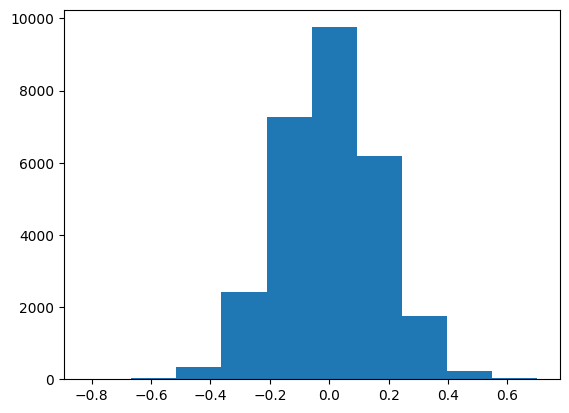

In [9]:
#Check if the generated noise model is correct!
# for voltafe and current magnitudes, the noise should be within 1%. For angles, itshould be within -0.4 and 0.4
d = va - VA.to_numpy()
plt.hist(d[:,10]) #Check for a random feature

### Solve the LSE

In [10]:
vm_tot =  np.zeros(vm.shape)
va_tot =  np.zeros(vm.shape)

# for case in range(1):
for case in range(vm.shape[0]):

    # --Part 1, calculating voltage (X) from the measurement vector (Z)--

    z = np.zeros(pmu_buses + m, dtype = np.complex128)
    for i in range(len(test_bus)):
        bus_idx =  int(test_bus[i])-1 #PMU location index
        z[i] = (vm[case, bus_idx])*np.exp(1j*va[case, bus_idx]*math.pi/180)
    idx = len(test_bus)
    for bus in test_bus:
        for ix, branch in enumerate(bdata):
            if branch[0]==bus: 
                z[idx]= cfm[case, ix]*np.exp(1j*cfa[case, ix]*math.pi/180)
                idx = idx+1
                # print(idx+1, branch[0], branch[1], 'from current')
            if branch[1]==bus: 
                z[idx]= ctm[case, ix]*np.exp(1j*cta[case, ix]*math.pi/180)
                idx = idx+1  
                # print(idx+1, branch[0], branch[1], 'to current')    

    if idx != z.shape[0]:
        print('not good!',idx)
        
    xhat = np.matmul(H,z)
    vm_tot[case,:] = abs(xhat)
    va_tot[case,:] = np.angle(xhat)*180/math.pi

In [12]:
vm_tot.shape

(28000, 118)

## Checking error

In [13]:
MAE_vm = np.zeros(bus_system)
MAE_va = np.zeros(bus_system)

MAPE_vm = np.zeros(bus_system)
MAPE_va = np.zeros(bus_system)

for i in range(bus_system):
    MAE_vm[i] = mean_absolute_error(vm_tot[:,i], vm[:,i]) 
    MAE_va[i] = mean_absolute_error(va_tot[:,i], va[:,i])     
    vm
    MAPE_vm[i] = mean_absolute_percentage_error(vm_tot[:,i], vm[:,i]) 
    MAPE_va[i] = mean_absolute_percentage_error(va_tot[:,i], va[:,i]) 


In [ ]:
MAE_va.shape

In [ ]:
vm_tot

In [14]:
# For the base topology (without topology change)
print(f'MAE_mag: {np.mean(MAE_vm):.5f}, MAPE_mag: {np.mean(MAPE_vm)*100:.5f}')
print(f'MAE_ang: {np.mean(MAE_va):.5f}, MAPE_ang: {np.mean(MAPE_va)*100:.5f}')

MAE_mag: 0.00281, MAPE_mag: 0.26961
MAE_ang: 0.14329, MAPE_ang: 0.66179


### LSE vs. DNN-SE

In [20]:
# Read DNN-SE results
path = r'C:\Users\smoshta1\OneDrive - Arizona State University\Desktop\DOE\BP2\Subtask 7.2\IEEE 118-bus System/'
DNN_MAPE_mag = pd.read_csv(path + 'DNN-SE_MAPE_mag.csv', header=None).to_numpy().squeeze()
DNN_MAE_ang = pd.read_csv(path + 'DNN-SE_MAE_ang.csv', header=None).to_numpy().squeeze()

In [21]:
# LSE results per bus
LSE_MAPE_mag = MAPE_vm * 100
LSE_MAE_ang = MAE_va

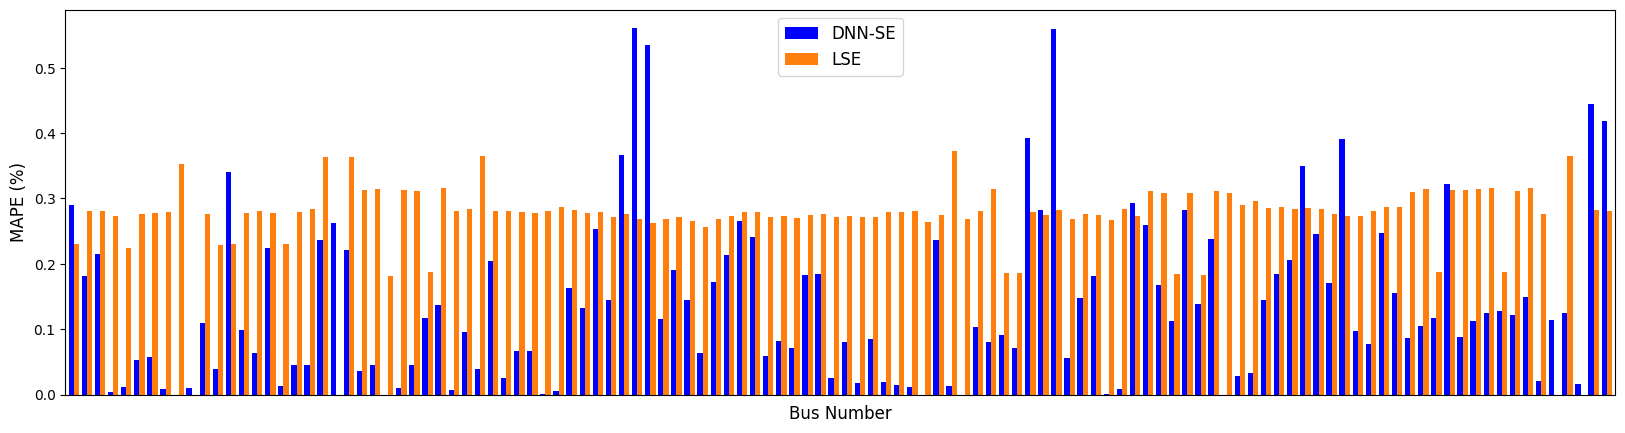

In [22]:
# create a DataFrame with the data
df = pd.DataFrame({'DNN-SE': DNN_MAPE_mag,
                   'LSE': LSE_MAPE_mag})
colors = ['blue', '#ff7f0e']
# plot the data as a double bar chart
ax = df.plot(kind='bar', figsize=(20,5), width=0.8, color=colors)


# increase the font size of the x and y axis labels
ax.set_xlabel('Bus Number', fontsize=12)
ax.set_ylabel('MAPE (%)', fontsize=12)

# set the legend to show above the chart
ax.legend(loc=9, fontsize=12)

# remove x-axis ticks
ax.set_xticks([])
ax.set_xticklabels([])

# show the chart
plt.show()

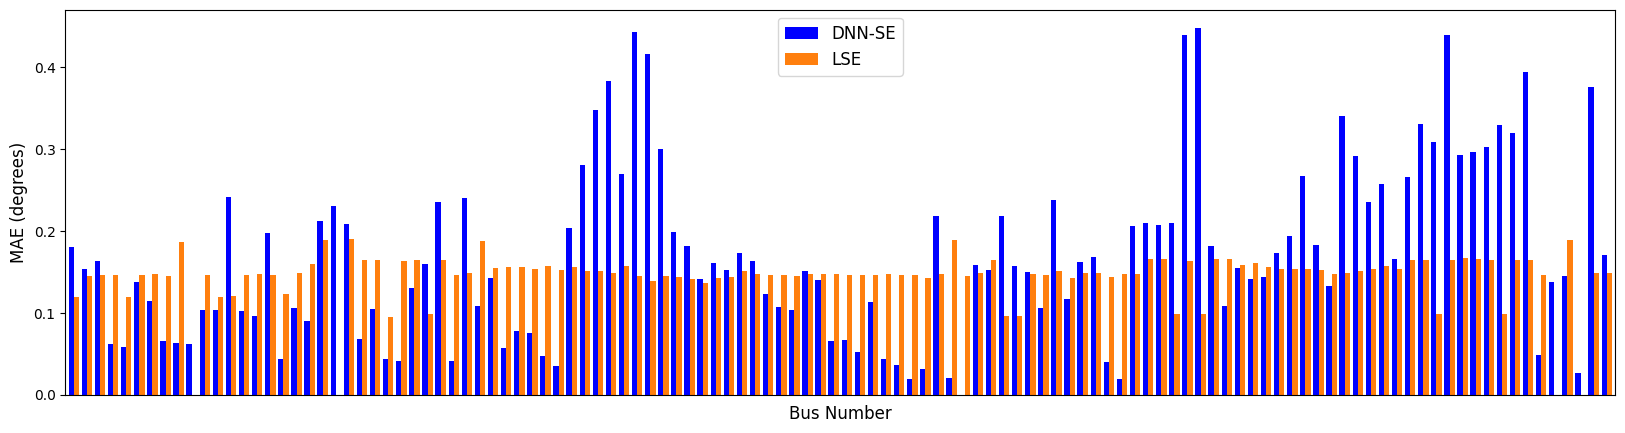

In [23]:
# create a DataFrame with the data
df = pd.DataFrame({'DNN-SE': DNN_MAE_ang,
                   'LSE': LSE_MAE_ang})
colors = ['blue', '#ff7f0e']
# plot the data as a double bar chart
ax = df.plot(kind='bar', figsize=(20,5), width=0.8, color=colors)


# increase the font size of the x and y axis labels
ax.set_xlabel('Bus Number', fontsize=12)
ax.set_ylabel('MAE (degrees)', fontsize=12)

# set the legend to show above the chart
ax.legend(loc=9, fontsize=12)

# remove x-axis ticks
ax.set_xticks([])
ax.set_xticklabels([])

# show the chart
plt.show()